# Getting started with SimPy
In this tutorial you will get to know the SimPy module for simulating discrete event systems. In this notebook you will see several examples of simple models implemented using SimPy, with some simple exercises following each example. After each exercise, you have the possibility to load the correct solution to check your answer.

Good luck!

## Import modules to be used

In [25]:
%matplotlib inline
import simpy
import random
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

## Example 1: A random process
We start off with a model of the hits received by a geiger counter measuring radioactivity. The time between hits is random and can be modelled as having an exponential distribution. The probability density function of the exponential distribution is given below

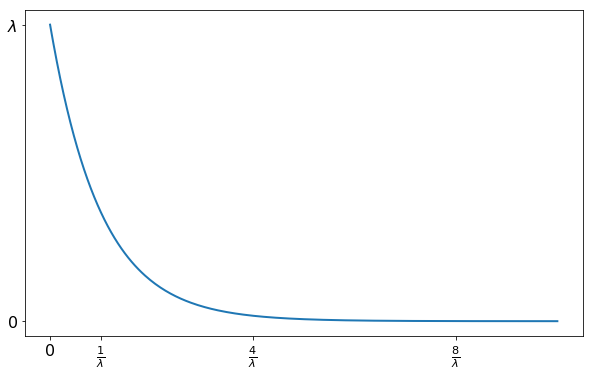

In [29]:
label_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

t = np.linspace(0, 10, 300)
lmbda = 1 # The frequency 
plt.figure(figsize=(10,6))
plt.plot(t, lmbda * np.exp(-t*lmbda), linewidth=2)
plt.yticks([0, lmbda], ['0', '$\lambda$'])
xt = plt.xticks([0, 1/lmbda, 4/lmbda, 8/lmbda], ['0', r'$\frac{1}{\lambda}$', r'$\frac{4}{\lambda}$', r'$\frac{8}{\lambda}$'])

## Example 1: A model of an intersection with traffic light
### The traffic light process
Consider the process of a simple traffic light that switches forever from red to green to yellow and back to red. The light is red for one minute, green for 50 seconds and yellow for 10 seconds.

The process will be implemented as a *generator* (see the notebook systemanalys/doc/Introduction to Python.ipynb). The process goes in an infinite loop, pausing in the different states correponding to the color of the light.

In [5]:
def traffic_light_proc(env):
    # The argument env is the simulation environment object. This is needed in order to interact with the simulator
    state = "red";
    while True:   
        # Neverending loop
        print("Time is %6.2f and the traffic light is %s" % (env.now, state))
        yield env.timeout(60) # A timeout event is returned to the simulator. 
        # The timout event will happen after 60 timeunits and then the process will continue 
     
        state = "green"
        print("Time is %6.2f and the traffic light is %s" % (env.now, state))
        yield env.timeout(50) # This event will happen after 50 timeunits.
        
        state = "yellow"
        print("Time is %6.2f and the traffic light is %s" % (env.now, state))
        yield env.timeout(10) # This event will happen after 10 timeunits
        
        state = "red"

env = simpy.Environment() # Create a simulation environment object
env.process(traffic_light_proc(env)) # Tell the environment to process the traffic light
env.run(until=600) # Run the simulation for 600 time units (10 minutes)

Time is   0.00 and the traffic light is red
Time is  60.00 and the traffic light is green
Time is 110.00 and the traffic light is yellow
Time is 120.00 and the traffic light is red
Time is 180.00 and the traffic light is green
Time is 230.00 and the traffic light is yellow
Time is 240.00 and the traffic light is red
Time is 300.00 and the traffic light is green
Time is 350.00 and the traffic light is yellow
Time is 360.00 and the traffic light is red
Time is 420.00 and the traffic light is green
Time is 470.00 and the traffic light is yellow
Time is 480.00 and the traffic light is red
Time is 540.00 and the traffic light is green
Time is 590.00 and the traffic light is yellow


### Checking the state (color) of the traffic light
The color of the traffic light is of course important in a simulation of an intersection. So this information should be readily available to other processes in the simulation model. We can modify the code above to obtain this, using a dictionary to hold the state of the traffic light.

In [7]:
trafficLight = {"state": "red"}
def traffic_light_proc(env, tl):
    # The argument env is the simulation environment object. 
    # The tl argument is a dictionary holding the state (color) of the traffic light
    tl['state'] = "red";
    while True:   
        # Neverending loop
        yield env.timeout(60) # A timeout event is returned to the simulator. 
     
        tl['state'] = "green"
        yield env.timeout(50) # This event will happen after 50 timeunits.
        
        tl['state'] = "yellow"
        yield env.timeout(10) # This event will happen after 10 timeunits
        
        tl['state'] = "red"

env = simpy.Environment() # Create a simulation environment object
env.process(traffic_light_proc(env, trafficLight)) # Tell the environment to process the traffic light

print("Time is %6.2f and the traffic light is %s" % (env.now, trafficLight['state']))
env.run(until=600) # Run the simulation for 600 time units (10 minutes)      
print("Time is %6.2f and the traffic light is %s" % (env.now, trafficLight['state']))

Time is   0.00 and the traffic light is red
Time is 600.00 and the traffic light is yellow


### A car approaches the intersection
It is time to make our model of the intersection somewhat more interesting. Consider the process of a car approaching the intersection. The driver will typically check the state of the traffic light. If it is green or yellow she will continue through the intersection. If the color is red she will stop and wait for the color to change. To make the implementation simpler (for now) we assume that the driver will check the light every eleven seconds to see if it has changed. 

In [14]:
def car_proc(env, tl):
    # Check the state of the traffic light
    if tl['state'] == 'red':
        # Break. Wait and check every 10 seconds until the light changes to green
        while tl['state'] == 'red':
            yield env.timeout(11)
        # Green! Time to go
        print( "Time is %6.2f and the light has changed to %s. Hitting the accelerator." % (env.now, tl['state']) )
    else:
        # Actually not much more to do than drive on
        print( "Time is %6.2f and the light is %s. Driving through." % (env.now, tl['state']) )

trafficLight['state'] = "red"

env = simpy.Environment() # Create a simulation environment object
env.process(traffic_light_proc(env, trafficLight)) # Tell the environment to process the traffic light
env.process(car_proc(env, trafficLight)) # Tell the environment to process the car process

print("Time is %6.2f and the traffic light is %s" % (env.now, trafficLight['state']))
env.run(until=600) # Run the simulation for 600 time units (10 minutes)      
print("Time is %6.2f and the traffic light is %s" % (env.now, trafficLight['state']))

Time is   0.00 and the traffic light is red
Time is  66.00 and the light has changed to green. Hitting the accelerator.
Time is 600.00 and the traffic light is yellow


### Exercise 1.1 Random arrival of the car
In the previous simulation model, the car arrived at the start of the simulation, exactly as the cycle of the traffic light started from red. In a more realistic model, the car arrives at some random point in time. Assume that the time from the start of the simulation until the car arrives at the intersection is modelled 